In [1]:
import os
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import re
# import io

# from pathlib import Path
# from typing import List, Optional

# import xml.dom.minidom as minidom
# import xml.etree.ElementTree as ET
# from xml.etree.ElementTree import Comment  # for comment detection



ModuleNotFoundError: No module named 'numpy'

# Generating hal config files for MERFISH runs

    This notebook is used to generate the shutter sequence to be imaged in each FOv
    then use that information to generate
        - the frame table, with the information for the shutter sequence, used to create config files
        - the Hal shutter file
        - the Hal config file
        - A printed version of the shutter sequence formated for clarity 
        - A grafical depiction of the shutter sequence
        
        
    all z positions are distance in microns from the locked focus, typically the coverslip
        
    a shutter sequence is determined by:
        - bead_z    :  z position where to take the bead sequence
                       The default is 
                           bead_z = 0
        
        - bead_seq  :  sequence of colors to acquire at the z_bead position to image the fiducial markers
                       The default is 
                           bead_seq = [488, np.nan]
                       that is, take a single 488 image at the coverlip position, then an empty frame
                       frame=0 is the beads
                           
        - color_seq :  sequence of colors to acquire at every z-position
                       The default is  
                           color_seq = [650,750]
                       if a empty frame is needed, us np.nan as the color, for example
                           color_seq = [np.nan, 650,750]
                       will take an empty frame at the beginning of each z position
                           
        - end_seq   :  aquisition before moving to a new FOV, typically, for going back to bead_z
                       The default is 
                           end_seq = [np.nan, np.nan]    
                           
        - z_min     :  first Z position at which acquire data 
        
        - z_max     :  last Z position at with acquire data
        
        - z_step    :  separation between z positions
        
        - z_pos     : Z positions to acquire, typically np.arange(z_min,z_max+z_step,z_step) 

In [15]:
local_dir       = f'../'
input_dir       = f'{local_dir}/input'
output_dir      = f'{local_dir}/output'

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Define shutter sequence (560, 650)

    set parameters that fully define the shutter sequence

In [16]:
bead_z    = 0                       # z position where to take the bead sequence
bead_seq  = [405, np.nan]           # color sequence to acquire at the z_bead position 
color_seq = [560,    650]           # color sequence to acquire at every position in z_pos 
end_seq   = [np.nan, np.nan]        # color sequence to acquire at the z_bead position after imaging all frames     
z_min     = 1                       # first Z position at which acquire data 
z_max     = 20                      # last Z position at with acquire data
z_step    = 0.5                     # separation between z positions
z_pos     = np.arange(z_min,        # Z positions to acquire 
                      z_max+z_step,
                      z_step)      

In [17]:
# generate frame table used to create shutter file and hal config
frame_table = get_frame_table(bead_z , bead_seq, color_seq , end_seq, z_pos, microscope='MF3')

# get a succint name for color sequence
color_seq_name = get_color_sequence_name(frame_table)

# print the name (or id) for color sequence
print(f'color sequence name: {color_seq_name}\n\n')

# print frame table in format simple to see
print_frame_table(frame_table)

# save frame table to disk
frame_table.to_csv(f'{output_dir}/{color_seq_name}_frame_table.csv')

# frame_table.head()

color sequence name: blkf3_405f1_560f39_650f39


frames            color             channel           z                 

     0     1         405   nan           4   nan        0.00  0.00
     2     3         560   650           2     1        1.00  1.00
     4     5         560   650           2     1        1.50  1.50
     6     7         560   650           2     1        2.00  2.00
     8     9         560   650           2     1        2.50  2.50
    10    11         560   650           2     1        3.00  3.00
    12    13         560   650           2     1        3.50  3.50
    14    15         560   650           2     1        4.00  4.00
    16    17         560   650           2     1        4.50  4.50
    18    19         560   650           2     1        5.00  5.00
    20    21         560   650           2     1        5.50  5.50
    22    23         560   650           2     1        6.00  6.00
    24    25         560   650           2     1        6.50  6.50
    26

In [18]:
# use frame table to create the shutter file
shutter_file_path = f'{output_dir}/{color_seq_name}_shutter.xml'
create_shutter_file(frame_table, shutter_file_path)

# read the created shutter file and display
print_xml_raw(shutter_file_path)

<?xml version="1.0" encoding="ISO-8859-1"?>
<repeat>
  <oversampling>1</oversampling>
  <frames>82</frames>

  <!-- z = 0 um, 405 beads-->
  <event>
    <channel>4</channel>
    <power>1.0</power>
    <on>0.0</on>
    <off>1.0</off>
  </event>

  <!-- z = 1 um-->
  <event>
    <channel>2</channel>
    <power>1.0</power>
    <on>2.0</on>
    <off>3.0</off>
  </event>
  <event>
    <channel>1</channel>
    <power>1.0</power>
    <on>3.0</on>
    <off>4.0</off>
  </event>

  <!-- z = 1.5 um-->
  <event>
    <channel>2</channel>
    <power>1.0</power>
    <on>4.0</on>
    <off>5.0</off>
  </event>
  <event>
    <channel>1</channel>
    <power>1.0</power>
    <on>5.0</on>
    <off>6.0</off>
  </event>

  <!-- z = 2 um-->
  <event>
    <channel>2</channel>
    <power>1.0</power>
    <on>6.0</on>
    <off>7.0</off>
  </event>
  <event>
    <channel>1</channel>
    <power>1.0</power>
    <on>7.0</on>
    <off>8.0</off>
  </event>

  <!-- z = 2.5 um-->
  <event>
    <channel>2</channel>
    <po

In [19]:
# create the hal config file from a reference file
prefix = 'hal-config-mf3-epi'
hal_config_path = create_hal_config(prefix, frame_table, xml_dir=input_dir, output_dir=output_dir)

# read the created hal file and display
print_xml_raw(hal_config_path)

<?xml version="1.0" encoding="ISO-8859-1"?>
<settings>

  <!-- camera settings -->
  <camera1>


    <!-- imaging settings -->
    <exposure_time type="float">0.2</exposure_time>


    <!-- view settings -->
    <colortable type="string">ramp.ctbl</colortable>
    <flip_horizontal type="int">0</flip_horizontal>
    <flip_vertical type="int">0</flip_vertical>
    <max_intensity type="int">65536</max_intensity>
    <transpose type="int">0</transpose>
    <scalemax type="int">2000</scalemax>
    <scalemin type="int">100</scalemin>
    <sync type="int">0</sync>
  </camera1>


  <!-- film settings -->
  <film>
    <acq_mode type="string">fixed_length</acq_mode>
    <auto_increment type="int">1</auto_increment>
    <auto_shutters type="int">1</auto_shutters>
    <filename type="string">test</filename> 
    <filetype type="string">.dax</filetype>
    <frames type="int">82</frames>
    <logfile type="string">F:\Data\image_log.txt</logfile>
    <want_bell type="int">1</want_bell>
  </film>
  



In [20]:
# recovered_df = read_shutter_file_to_frame_table(shutter_file_path, microscope='MF3')
# print_frame_table(recovered_df)

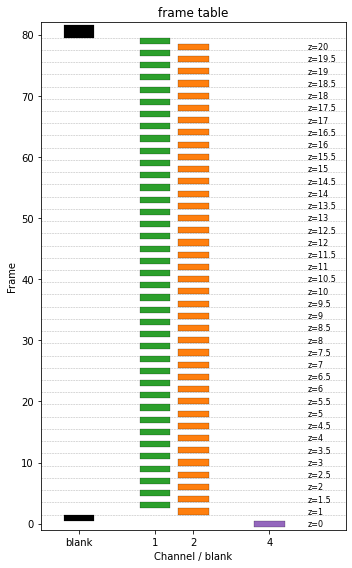

In [21]:
# shutter_df = read_shutter_file_to_frame_table(shutter_file_path, microscope='MF3')
visualize_shutter_sequence(frame_table, 
                           title="frame table", 
                           savepath=f'{output_dir}/{color_seq_name}_shutter_sequence.png')

# Define shutter sequence (405, 488)
    set parameters that fully define the shutter sequence

In [22]:
bead_z    = 0                       # z position where to take the bead sequence
bead_seq  = [405, np.nan]           # color sequence to acquire at the z_bead position 
color_seq = [405,    488]           # color sequence to acquire at every position in z_pos 
end_seq   = [np.nan, np.nan]        # color sequence to acquire at the z_bead position after imaging all frames     
z_min     = 1                       # first Z position at which acquire data 
z_max     = 20                      # last Z position at with acquire data
z_step    = 0.5                     # separation between z positions
z_pos     = np.arange(z_min,        # Z positions to acquire 
                      z_max+z_step,
                      z_step)      

In [23]:
# generate frame table used to create shutter file and hal config
frame_table = get_frame_table(bead_z , bead_seq, color_seq , end_seq, z_pos, microscope='MF3')

# get a succint name for color sequence
color_seq_name = get_color_sequence_name(frame_table)

# print the name (or id) for color sequence
print(f'color sequence name: {color_seq_name}\n\n')

# print frame table in format simple to see
print_frame_table(frame_table)

# save frame table to disk
frame_table.to_csv(f'{output_dir}/{color_seq_name}_frame_table.csv')

# frame_table.head()

color sequence name: blkf3_405f40_488f39


frames            color             channel           z                 

     0     1         405   nan           4   nan        0.00  0.00
     2     3         405   488           4     3        1.00  1.00
     4     5         405   488           4     3        1.50  1.50
     6     7         405   488           4     3        2.00  2.00
     8     9         405   488           4     3        2.50  2.50
    10    11         405   488           4     3        3.00  3.00
    12    13         405   488           4     3        3.50  3.50
    14    15         405   488           4     3        4.00  4.00
    16    17         405   488           4     3        4.50  4.50
    18    19         405   488           4     3        5.00  5.00
    20    21         405   488           4     3        5.50  5.50
    22    23         405   488           4     3        6.00  6.00
    24    25         405   488           4     3        6.50  6.50
    26    27

In [24]:
# use frame table to create the shutter file
shutter_file_path = f'{output_dir}/{color_seq_name}_shutter.xml'
create_shutter_file(frame_table, shutter_file_path)

# read the created shutter file and display
print_xml_raw(shutter_file_path)

<?xml version="1.0" encoding="ISO-8859-1"?>
<repeat>
  <oversampling>1</oversampling>
  <frames>82</frames>

  <!-- z = 0 um, 405 beads-->
  <event>
    <channel>4</channel>
    <power>1.0</power>
    <on>0.0</on>
    <off>1.0</off>
  </event>

  <!-- z = 1 um-->
  <event>
    <channel>4</channel>
    <power>1.0</power>
    <on>2.0</on>
    <off>3.0</off>
  </event>
  <event>
    <channel>3</channel>
    <power>1.0</power>
    <on>3.0</on>
    <off>4.0</off>
  </event>

  <!-- z = 1.5 um-->
  <event>
    <channel>4</channel>
    <power>1.0</power>
    <on>4.0</on>
    <off>5.0</off>
  </event>
  <event>
    <channel>3</channel>
    <power>1.0</power>
    <on>5.0</on>
    <off>6.0</off>
  </event>

  <!-- z = 2 um-->
  <event>
    <channel>4</channel>
    <power>1.0</power>
    <on>6.0</on>
    <off>7.0</off>
  </event>
  <event>
    <channel>3</channel>
    <power>1.0</power>
    <on>7.0</on>
    <off>8.0</off>
  </event>

  <!-- z = 2.5 um-->
  <event>
    <channel>4</channel>
    <po

In [25]:
# create the hal config file from a reference file
prefix = 'hal-config-mf3-epi'
hal_config_path = create_hal_config(prefix, frame_table, xml_dir=input_dir, output_dir=output_dir)

# read the created hal file and display
print_xml_raw(hal_config_path)

<?xml version="1.0" encoding="ISO-8859-1"?>
<settings>

  <!-- camera settings -->
  <camera1>


    <!-- imaging settings -->
    <exposure_time type="float">0.2</exposure_time>


    <!-- view settings -->
    <colortable type="string">ramp.ctbl</colortable>
    <flip_horizontal type="int">0</flip_horizontal>
    <flip_vertical type="int">0</flip_vertical>
    <max_intensity type="int">65536</max_intensity>
    <transpose type="int">0</transpose>
    <scalemax type="int">2000</scalemax>
    <scalemin type="int">100</scalemin>
    <sync type="int">0</sync>
  </camera1>


  <!-- film settings -->
  <film>
    <acq_mode type="string">fixed_length</acq_mode>
    <auto_increment type="int">1</auto_increment>
    <auto_shutters type="int">1</auto_shutters>
    <filename type="string">test</filename> 
    <filetype type="string">.dax</filetype>
    <frames type="int">82</frames>
    <logfile type="string">F:\Data\image_log.txt</logfile>
    <want_bell type="int">1</want_bell>
  </film>
  



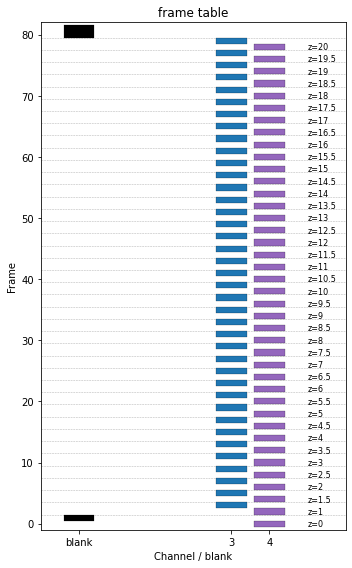

In [26]:
# shutter_df = read_shutter_file_to_frame_table(shutter_file_path, microscope='MF3')
visualize_shutter_sequence(frame_table, 
                           title="frame table", 
                           savepath=f'{output_dir}/{color_seq_name}_shutter_sequence.png')